<a href="https://colab.research.google.com/github/hrushikeshsahu19/Predicting-the-news-popularity-in-multiple-social-media-platforms/blob/main/Hrushikesh_Sahu_team_4_of_News_Popularity_Prediction_in_Social_Media_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting the news popularity in multiple social media platforms. </u></b>

## <b> Problem Description </b>

### This is a large data set of news items and their respective social feedback on multiple platforms: Facebook, Google+ and LinkedIn.The collected data relates to a period of 8 months, between November 2015 and July 2016, accounting for about 100,000 news items on four different topics: Economy, Microsoft, Obama and Palestine.


## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### IDLink (numeric): Unique identifier of news items
* ### Title (string): Title of the news item according to the official media sources
* ### Headline (string): Headline of the news item according to the official media sources
* ### Source (string): Original news outlet that published the news item
* ### Topic (string): Query topic used to obtain the items in the official media sources
* ### PublishDate (timestamp): Date and time of the news items' publication
* ### SentimentTitle (numeric): Sentiment score of the text in the news items' title
* ### SentimentHeadline (numeric): Sentiment score of the text in the news items' headline
* ### Facebook (numeric): Final value of the news items' popularity according to the social media source Facebook
* ### GooglePlus (numeric): Final value of the news items' popularity according to the social media source Google+
* ### LinkedIn (numeric): Final value of the news items' popularity according to the social media source LinkedIn


### VARIABLES OF SOCIAL FEEDBACK DATA

* ### IDLink (numeric): Unique identifier of news items
* ### TS1 (numeric): Level of popularity in time slice 1 (0-20 minutes upon publication)
* ### TS2 (numeric): Level of popularity in time slice 2 (20-40 minutes upon publication)
* ### TS... (numeric): Level of popularity in time slice ...
* ### TS144 (numeric): Final level of popularity after 2 days upon publication

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix
from string import punctuation
from nltk.corpus import stopwords
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import spacy
from spacy.lang.en import English
from sklearn.model_selection import GridSearchCV
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
punctuation=list(punctuation)
punctuation.append("..")


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
news_df=pd.read_csv("/content/drive/MyDrive/Almabetter/Cohort Aravali/Module 4/Capstone-3 /Copy of News_Final.csv")

In [ ]:
news_df.shape

(93239, 11)

In [ ]:
news_df.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


In [ ]:
news_df['Source'].value_counts()

Bloomberg                               1732
Reuters                                 1321
ABC News                                1098
New York Times                           992
The Guardian                             933
                                        ... 
KEYE TV                                    1
State of the State KS (subscription)       1
Daily Echo                                 1
KYMA                                       1
Bharat Times                               1
Name: Source, Length: 5756, dtype: int64

In [ ]:
news_df.dropna(inplace=True,axis=0)

In [ ]:
news_df.isnull().sum()

IDLink               0
Title                0
Headline             0
Source               0
Topic                0
PublishDate          0
SentimentTitle       0
SentimentHeadline    0
Facebook             0
GooglePlus           0
LinkedIn             0
dtype: int64

In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92945 entries, 0 to 93238
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             92945 non-null  float64
 1   Title              92945 non-null  object 
 2   Headline           92945 non-null  object 
 3   Source             92945 non-null  object 
 4   Topic              92945 non-null  object 
 5   PublishDate        92945 non-null  object 
 6   SentimentTitle     92945 non-null  float64
 7   SentimentHeadline  92945 non-null  float64
 8   Facebook           92945 non-null  int64  
 9   GooglePlus         92945 non-null  int64  
 10  LinkedIn           92945 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 8.5+ MB


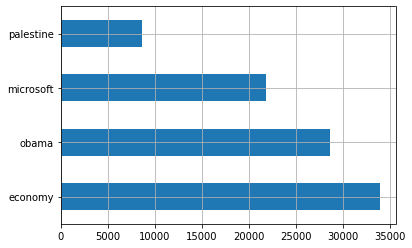

In [ ]:
news_df['Topic'].value_counts().plot(kind='barh',grid=True)

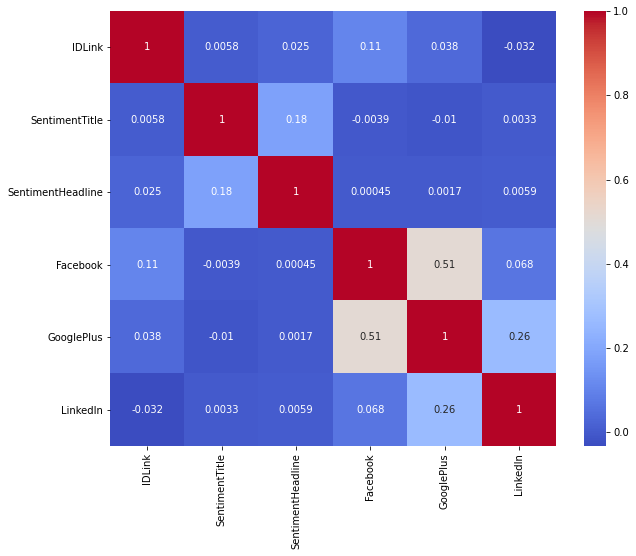

In [ ]:

plt.figure(figsize=(10,8))
sns.heatmap(data=news_df.corr(),cmap='coolwarm',annot=True)

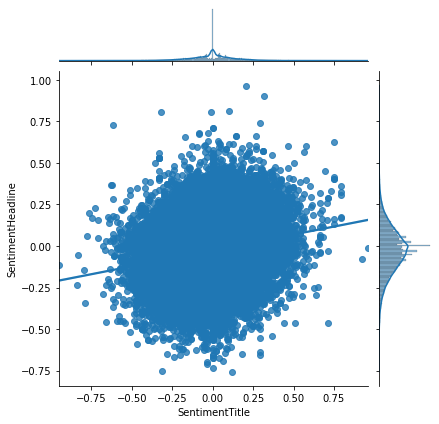

In [ ]:
sns.jointplot(x='SentimentTitle',y='SentimentHeadline',data=news_df,kind = 'reg')
plt.show()

In [ ]:

news_df.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


In [ ]:
news_df['Text']=news_df['Title']+news_df['Headline']

In [ ]:
def Change_text(msg):
  punc=[char for char in msg if char not in punctuation]
  no_punc=''.join(punc)
  main_text=[word for word in no_punc.split() if word.lower() not in stopwords.words('english')]
  return ' '.join(main_text)

In [ ]:
news_df.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,Text
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1,Obama Lays Wreath at Arlington National Cemete...
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1,A Look at the Health of the Chinese EconomyTim...
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1,Nouriel Roubini: Global Economy Not Back to 20...
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1,Finland GDP Expands In Q4Finland's economy exp...
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1,"Tourism, govt spending buoys Thai economy in J..."


In [ ]:
news_df['token_text']=news_df['Text'].apply(Change_text)


In [ ]:
news_df['Text'][1]

'A Look at the Health of the Chinese EconomyTim Haywood, investment director business-unit head for fixed income at Gam, discusses the China beige book and the state of the economy.'

# **Linear Regression** 

# **On Facebook** 

In [ ]:
X=news_df['token_text']
Y=news_df['Facebook']

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

In [ ]:
vector=TfidfVectorizer(max_df = 0.8,min_df = 8)

In [ ]:
model=LinearRegression()
pipe_title = Pipeline([('vectorizer', vector),
                     ('regressor', model)])
pipe_title.fit(X_train,Y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=None,
                                 min_df=8, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('regressor',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
  

In [ ]:
test_pred_text=pipe_title.predict(X_test)

In [ ]:
def print_metrics(actual, predicted):
  print('MSE is {}'.format(mean_squared_error(actual, predicted)))
  print('RMSE is {}'.format(math.sqrt(mean_squared_error(actual, predicted))))
  print('r2 score is {}'.format(r2_score(actual, predicted)))
  print('MAE is {}'.format(mean_absolute_error(actual, predicted)))
  print('MAPE is {}'.format(np.mean(np.abs((actual - predicted) / actual)) * 100))

In [ ]:
print_metrics(Y_test,test_pred_text)

MSE is 422126.03507856163
RMSE is 649.7122709927538
r2 score is -0.1594327118754868
MAE is 277.9330093781675
MAPE is inf


# **On Linkedin**

In [ ]:
X=news_df['token_text']
Y=news_df['LinkedIn']

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

In [ ]:
model=LinearRegression()
pipe_title = Pipeline([('vectorizer', vector),
                     ('regressor', model)])
pipe_title.fit(X_train,Y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=None,
                                 min_df=8, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('regressor',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
  

In [ ]:
test_pred_text=pipe_title.predict(X_test)

In [ ]:
print_metrics(Y_test,test_pred_text)

MSE is 29149.577414493466
RMSE is 170.73247322783521
r2 score is -0.027885464104569158
MAE is 48.84907695539932
MAPE is inf


# **On GooglePlus**

In [ ]:
X=news_df['token_text']
Y=news_df['GooglePlus']

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

In [ ]:
model=LinearRegression()
pipe_title = Pipeline([('vectorizer', vector),
                     ('regressor', model)])
pipe_title.fit(X_train,Y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=None,
                                 min_df=8, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('regressor',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
  

In [ ]:
test_pred_text=pipe_title.predict(X_test)

In [ ]:
print_metrics(Y_test,test_pred_text)

MSE is 495.39768647323484
RMSE is 22.25753100577948
r2 score is -0.1386350988502787
MAE is 8.664402565122636
MAPE is inf


# **By using spacy library**

In [ ]:
nlp=spacy.load("en_core_web_sm")
nlp

In [ ]:
text="Africa Haywood, add adding investment director business-unit head for fixed income at Gam, discusses the China beige book and the state of the economy."
mytokens_nlp = nlp(text)
entity=[str(i) for i in mytokens_nlp.ents ]
mytokens=[word for word in mytokens_nlp if word.text not in entity ] 
mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-"  else word.lower_ for word in mytokens   ]
mytokens = [ word for word in mytokens if word not in STOP_WORDS and word not in punctuation and len(word)>3]

print(mytokens)
print(entity)

['africa', 'haywood', 'investment', 'director', 'business', 'unit', 'head', 'income', 'discuss', 'beige', 'book', 'state', 'economy']
['Africa Haywood', 'Gam', 'China']


In [ ]:
def spacy_tokenizer(sentence):
   mytokens_nlp = nlp(sentence)
   entity=[str(i) for i in mytokens_nlp.ents ]
   mytokens=[word for word in mytokens_nlp if word.text not in entity ] 
   mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-"  else word.lower_ for word in mytokens  ]
   mytokens = [ word for word in mytokens if word not in STOP_WORDS and word not in punctuation and len(word)>3]
   return ' '.join(mytokens)

In [ ]:
news_df['Spacy_token']=news_df['Text'].apply(spacy_tokenizer)

In [ ]:
news_df.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,Text,token_text,Spacy_token
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1,Obama Lays Wreath at Arlington National Cemete...,Obama Lays Wreath Arlington National CemeteryO...,obama lays wreath arlington national cemeteryo...
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1,A Look at the Health of the Chinese EconomyTim...,Look Health Chinese EconomyTim Haywood investm...,look health chinese economytim haywood investm...
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1,Nouriel Roubini: Global Economy Not Back to 20...,Nouriel Roubini Global Economy Back 2008Nourie...,nouriel global economy professor chairman glob...
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1,Finland GDP Expands In Q4Finland's economy exp...,Finland GDP Expands Q4Finlands economy expande...,expand q4finland economy expand marginally mon...
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1,"Tourism, govt spending buoys Thai economy in J...",Tourism govt spending buoys Thai economy Janua...,tourism govt spending buoy economy public spen...


# **On Facebook** 

# **Random Forest model**

In [ ]:
X=news_df['Spacy_token']
Y=news_df['Facebook']

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

In [ ]:
vector=TfidfVectorizer(max_df = 0.9,min_df = 9)

In [ ]:
model=RandomForestRegressor(n_estimators=50,max_depth=None,random_state=0)
pipe_title = Pipeline([('vectorizer', vector),
                     ('regressor', model)])
pipe_title.fit(X_train,Y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.9, max_features=None,
                                 min_df=9, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                      

In [ ]:
test_pred_text=pipe_title.predict(X_test)

In [ ]:
print_metrics(Y_test,test_pred_text)

MSE is 538674.1923775814
RMSE is 733.9442706211292
r2 score is 0.015130753873194513
MAE is 158.22328344744986
MAPE is inf


# **USing PCA**

In [ ]:
Google_pop=news_df[news_df['GooglePlus']!=-1]

In [ ]:
data=Google_pop['Spacy_token'].iloc[:5000]

In [ ]:
v = TfidfVectorizer(max_df=0.1,min_df=10)
x = v.fit_transform(data)

In [ ]:
df1 = pd.DataFrame(x.toarray(), columns=v.get_feature_names())


In [ ]:
df1.shape

(5000, 1325)

In [ ]:
df1 = df1.loc[:, ~df1.columns.str[0].str.isnumeric()]

In [ ]:
df1.head()

,ability,able,abroad,academic,accelerate,accept,access,accord,account,accuse,achieve,acknowledge,acquire,acquisition,action,activist,activity,actually,addition,additional,address,administration,admit,adopt,advanced,adviser,affair,affect,affordable,africa,agency,agenda,agree,agreement,ahead,alliance,allow,ally,alternative,america,...,washington,watch,wave,we,weak,weaken,weather,website,week,weekend,weigh,welcome,west,western,white,wide,widely,wind,window,windows,winner,woman,word,work,worker,workforce,world,worldwide,worried,worry,worth,write,wrong,xbox,year,york,young,youth,zealand,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.152819,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.232935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.202326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.180946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090074,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.154303,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.134975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
df1['Sentiment_headline']=news_df['SentimentHeadline'].iloc[:5000]

In [ ]:
df1['Sentiment_title']=news_df['SentimentTitle'].iloc[:5000]

In [ ]:
df1=df1.fillna(df1.median())

In [ ]:
Y=news_df['GooglePlus'].iloc[0:5000]

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(df1,Y,test_size=0.2)

In [ ]:
model=LinearRegression().fit(X_train,Y_train)

In [ ]:
test_pred_text=model.predict(X_test)

In [ ]:
print_metrics(Y_test,test_pred_text)

MSE is 452.29031794828137
RMSE is 21.267118233279312
r2 score is -1.0525430965597629
MAE is 12.731419670891372
MAPE is inf


# **Random Forest With PCA**

In [ ]:
n_estimators = np.arange(40,150,20)
max_depth = np.arange(5,20,3)
min_samples_split = [20,30,50]
min_samples_leaf = [40,50,60]
bootstrap = [True]

In [ ]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': [True]
              }

print(random_grid)

{'n_estimators': array([ 40,  60,  80, 100, 120, 140]), 'max_depth': array([ 5,  8, 11, 14, 17]), 'min_samples_split': [20, 30, 50], 'min_samples_leaf': [40, 50, 60], 'bootstrap': [True]}


In [ ]:
# First create the base model to tune
rf = RandomForestRegressor()
rf_random = GridSearchCV(estimator = rf,
                         param_grid=random_grid,
                         cv = 3,
                         verbose=2,
                         n_jobs = -1)

rf_random.fit(X_train,Y_train)

Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 42.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 87.7min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 116.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=60,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=60, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
random_forest=rf_random.best_estimator_

In [ ]:
y_preds=random_forest.predict(X_test)

In [ ]:
print_metrics(Y_test,y_preds)

MSE is 564.4168906613336
RMSE is 23.757459684514536
r2 score is 0.01747665896177686
MAE is 7.200742072030062
MAPE is inf


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


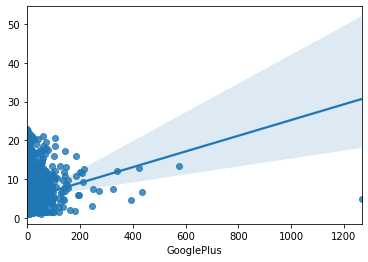

In [ ]:
sns.regplot(Y_test,y_preds)

In [ ]:
xgb=XGBRegressor()
xgb.fit(X_train,Y_train)

[15:19:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
y_preds_xgb=xgb.predict(X_test)
print_metrics(Y_test,y_preds_xgb)

MSE is 412.3954252935306
RMSE is 20.307521397096462
r2 score is -0.008229448140890439
MAE is 7.5282956354220705
MAPE is inf


# **Vectorizer**

In [ ]:


tittle_vector=vectorize.fit_transform(news_df['token_text'])

In [ ]:
vectorize=TfidfVectorizer(max_df = 0.9,min_df = 10)

headline_vector=vectorize.fit_transform(news_df['tokenize_headline'])

In [ ]:

import numpy as np
import pandas as pd
import csv
from datetime import datetime
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
def parsedata(filename):
    articles = {}

    with open(filename, 'r') as csvfile:
        ifile = csv.reader(csvfile)
        next(ifile, None) #skip header
        for line in ifile:
            instance = []
            flag = False
            for val in line:
                if flag:
                    instance.append(val)
                else:
                    id_link = val
                    flag = True
            articles[id_link] = instance
            
    return articles



In [ ]:
def organize_topics(articles):
    topics = {'economy': [], 'microsoft': [], 'obama': [], 'palestine': []}

    for i in articles:
        if articles[i][3] == 'economy':
            topics['economy'].append(i)
        elif articles[i][3] == 'microsoft':
            topics['microsoft'].append(i)
        elif articles[i][3] == 'obama':
            topics['obama'].append(i)
        else:
            topics['palestine'].append(i)

    return topics



In [ ]:
def replace_NegOnes(articles, topics):
    econ_avg_fb, econ_avg_gp, econ_avg_li = get_avg_pop(articles, topics, 'economy')
    micro_avg_fb, micro_avg_gp, micro_avg_li = get_avg_pop(articles, topics, 'microsoft')
    obama_avg_fb, obama_avg_gp, obama_avg_li = get_avg_pop(articles, topics, 'obama')
    pal_avg_fb, pal_avg_gp, pal_avg_li = get_avg_pop(articles, topics, 'palestine')

    for i in articles:
        if articles[i][3] == 'economy':
            if float(articles[i][7]) == -1.:
                articles[i][7] = econ_avg_fb
            if float(articles[i][8]) == -1.:
                articles[i][8] = econ_avg_gp
            if float(articles[i][9]) == -1.:
                articles[i][9] = econ_avg_li
        elif articles[i][3] == 'microsoft':
            if float(articles[i][7]) == -1.:
                articles[i][7] = micro_avg_fb
            if float(articles[i][8]) == -1.:
                articles[i][8] = micro_avg_gp
            if float(articles[i][9]) == -1.:
                articles[i][9] = micro_avg_li
        elif articles[i][3] == 'obama':
            if float(articles[i][7]) == -1.:
                articles[i][7] = obama_avg_fb
            if float(articles[i][8]) == -1.:
                articles[i][8] = obama_avg_gp
            if float(articles[i][9]) == -1.:
                articles[i][9] = obama_avg_li
        else:
            if float(articles[i][7]) == -1.:
                articles[i][7] = pal_avg_fb
            if float(articles[i][8]) == -1.:
                articles[i][8] = pal_avg_gp
            if float(articles[i][9]) == -1.:
                articles[i][9] = pal_avg_li
    return articles



In [ ]:
rated_dummies = pd.get_dummies(news_df['Topic'])
news_df=pd.concat([news_df, rated_dummies], axis=1)

In [ ]:
def get_avg_pop(articles, topics_dict, topic):
    sum_fb = 0
    sum_gp = 0
    sum_li = 0
    count_fb = 0
    count_gp = 0
    count_li = 0

    for i in topics_dict[topic]:
        if float(articles[i][7]) != -1.:
            sum_fb += float(articles[i][7])
            count_fb += 1.
        if float(articles[i][8]) != -1.:
            sum_gp += float(articles[i][8])
            count_gp += 1.
        if float(articles[i][9]) != -1.:
            sum_li += float(articles[i][9])
            count_li += 1.
    avg_fb = sum_fb/count_fb
    avg_gp = sum_gp/count_gp
    avg_li = sum_li/count_li

    return avg_fb, avg_gp, avg_li

def add_seconds_from_date(articles):
    start_date = '1970-01-01 '
    for i in articles:
        date = articles[i][4].split(" ")
        date = start_date + date[1]
        articles[i][4] = get_seconds(date)

    return articles

def get_seconds(date):
    datetime_object = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    return datetime_object.timestamp() - 28800.

def create_dataframe(articles):
    data_init = []
    for i in articles:
        temp = []
        fcount = 0
        for val in articles[i]:
            if fcount in (0, 1, 2):
                fcount += 1
                continue
            elif fcount == 3:
                if val == "economy":
                    temp.append(1)
                    temp.append(0)
                    temp.append(0)
                    temp.append(0)
                elif val == "microsoft":
                    temp.append(0)
                    temp.append(1)
                    temp.append(0)
                    temp.append(0)
                elif val == "obama":
                    temp.append(0)
                    temp.append(0)
                    temp.append(1)
                    temp.append(0)
                else:
                    temp.append(0)
                    temp.append(0)
                    temp.append(0)
                    temp.append(1)
            else:
                temp.append(float(val))
            fcount += 1
        data_init.append(temp)

    data = pd.DataFrame(np.matrix(data_init))
    data.columns = ['Economy', 'Microsoft', 'Obama', 'Palestine', 'Time (s)', 'SentimentTitle', 'SentimentHeadline', 'Facebook', 'GooglePlus', 'LinkedIn']

    return data


In [ ]:
articles = parsedata('/content/drive/MyDrive/Almabetter/Cohort Aravali/Module 4/Capstone-3 /Copy of News_Final.csv')
topics = organize_topics(articles)
articles2 = replace_NegOnes(articles, topics)
articles3 = add_seconds_from_date(articles2)
garbage = create_dataframe(articles)

In [ ]:
garbage.head()

,Economy,Microsoft,Obama,Palestine,Time (s),SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,0.0,0.0,1.0,0.0,-28800.0,0.000000,-0.053300,304.035623,7.227951,8.724642
1,1.0,0.0,0.0,0.0,-28800.0,0.208333,-0.156386,46.230544,1.779149,16.978678
2,1.0,0.0,0.0,0.0,-28800.0,-0.425210,0.139754,46.230544,1.779149,16.978678
3,1.0,0.0,0.0,0.0,-28440.0,0.000000,0.026064,46.230544,1.779149,16.978678
4,1.0,0.0,0.0,0.0,-28140.0,0.000000,0.141084,46.230544,1.779149,16.978678


In [ ]:
x = garbage.drop(labels=['Facebook','GooglePlus','LinkedIn'],axis=1)
y=garbage['GooglePlus']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.25,random_state=1)

In [ ]:
model=LinearRegression().fit(x_train,y_train)

In [ ]:
y_preds=model.predict(x_test)

In [ ]:
print_metrics(y_test,y_preds)

MSE is 311.8155288887206
RMSE is 17.65829915050486
r2 score is 0.01773706908742212
MAE is 5.538173260612132
MAPE is inf


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


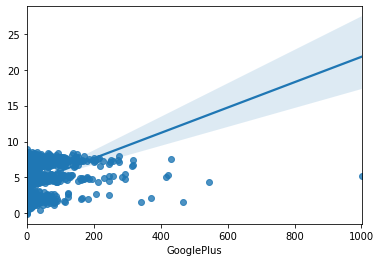

In [ ]:
sns.regplot(y_test,y_preds)